# The News Trend Predictor - Research & Development of News Trend Prediction Strategies & Methodologies

#### Student Names & IDs:
- Liam Fitzmaurice - S.N. 14027149
- Shance Zhao (Alex) - S.N. 24013122
- Zhuonan Mai (Miranda) - S.N. 19044660


# Introduction
Group 2 presents the development of The News Trend Predictor app - a web app targeted at journalists, social media personalities/marketers, and anyone wishing to know the likely relevancy of a news item in the near future, based on its recent trajectory.

The News Trend Predictor’s target prediction variable is the Google Trend of the given news text string - this is a self-relative and normalised (to a 0-100 range) measure of popularity based on the number of Google searches containing the string - using this as the target variable is directly relevant to the target users, as it is useful data to have for developing search engine optimisation strategies when publishing news articles, writing social media posts, or generating any content that relies on algorithmic content discovery to reach viewers.
This report documents our journey through the data wrangling, analysis, predictive modelling, and app development processes, the successes and roadblocks we faced, and our resulting key findings.


#### Datasets used:
1. Google Search Trend data for each relative News Item analysed.
2. Custom-generated calendar dataset.
3. Custom-generated dataset of each relative News Item’s most popular keyword-related YouTube videos during the given timeframes.


#### Dataset sources: 
1. Trend data is scraped from https://trends.google.com/trends/ using the Python model “PyTrends”.
2. The calendar dataset was internally created by us.
3. Data is fetched from YouTube API through community-donated API keys at https://yt.lemnoslife.com/


### Research Questions
1. Are prediction algorithms effective in predicting the popularity trend of individual news items?
2. How do the quality and source of data impact the reliability of news trend forecasts?
3. What is the relationship between the data and different categories/types of news (e.g. short-term, medium-term, and long-term news items)?
4. Which machine learning algorithms are most effective and appropriate for this type of prediction/forecast?


### Executive Summary
The News Trend Predictor app forecasts the relevancy of news items by leveraging Google Trend data, normalised to a 0-100 scale. Aimed at journalists and content creators, the app uses historical data from YouTube and Google Trends to overcome access restrictions on other platforms.
Our research explored the effectiveness of prediction algorithms, data quality impacts, and optimal machine learning methods. Key findings indicate that small datasets and highly correlated features can lead to overfitting and poor predictive performance, underscoring the need for adequate data and efficient feature selection.

#### Modules

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statistics
import plotly.graph_objs as go
from datetime import datetime
import math
import json
from pathlib import Path
import time
from TrendProcesses import FetchData, CreateFeatures, RunAnalysis, RunModels
import plotly.express as px
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.cluster import KMeans

from scipy.stats import mode
import seaborn as sns    
from sklearn.preprocessing import RobustScaler, StandardScaler,MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,accuracy_score
import statsmodels.formula.api as smf
#from handle_model_util import handle_yt_data, handle_tr_data,normalize_trend
from pylab import rcParams
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'

# Data Wrangling
At the beginning of our project, we faced significant challenges in our attempts to find and integrate historic hashtag and "keyword mention" data sources. Many websites, including major platforms such as X, Meta (Facebook and Instagram) and TikTok, require application registration, the upload of personal identification, and a clear explanation of the data collection purpose. This process proved to be cumbersome and time-consuming, often resulting in delays and additional administrative burdens. Despite these efforts, access to the desired historical data remained limited, prompting us to explore alternative sources.

In order to use readily accessable hashtag and keyword mention data from these sources, we would need to create an automatic script to fetch predetermined news item strings from their respective API's, run it daily, and use the results to build our own historic datasets - doing this would severely limit any app functionality, as the selected news items would need to be known up to 30 days in advance, which is not possible.

Ultimately, we settled on using YouTube and Google trends data for our project. YouTube provided a readily-accessible repository of historical content and keyword mentions, while calendar data offered valuable insights into trends and events over time. This combination allowed us to circumvent the stringent requirements of other platforms and focus on the analysis and integration of accessible and relevant data, thus streamlining our research process and enhancing the quality of our findings.

Liam noted the similarity of data sources from a prior project of his - but that our usage is significantly different enough to warrant using them, and that our results would differ due to this. Specifically, that we are purely using YouTube data as predictive features to predict the Google Trend (and not YouTube views), that our gathered data is not limited to a single YouTube account, our use of external calendar features, and our project having vastly different research goals.

After testing the data gathering methods below, we decided to limit our scope to 30 days of gathered data, and limit forecast predictions made from that data to a maximum of 1 day.

#### Data Gathering
For each news item, the following steps are taken:
1. Google Trends data is fetched for the news item string (1 API call).
2. 30 YouTube api calls are made to gather the top 1-3 videos relevant to the news item string (30 API calls).
3. 1 API call is made for each video ID fetched, to gather video statistics (30-90 API calls).

The code below is commented out and replaced with a raw csv data read - data is for the news item "Palistine" - data is aligned later:

In [115]:
#data_fetcher = FetchData(raw_data_loader)
#trend, yt_data = data_fetcher.fetch_and_return_final_df_list("palistine")

all_trends = pd.read_csv('./data/test_trends_data.csv')
trend = all_trends.loc[:, ["date", all_trends.columns[1]]]
yt_data = pd.read_csv('./data/test_yt_data.csv')

print("Trend data:")
print(trend.head())
print('')
print("YouTube Initial data:")
print(yt_data.head())

Trend data:
         date  palistine
0  2024-05-01         97
1  2024-05-02        100
2  2024-05-03         48
3  2024-05-04         44
4  2024-05-05         42

YouTube Initial data:
         date  views  likes  comments
0  2024-05-03  17894   3611        99
1  2024-05-03  18462   1718       104
2  2024-05-03  43857  10830       273
3  2024-05-04  90220    730       794
4  2024-05-04  14960   1418        75


#### Data Preparation & Feature Engineering
Preparing data is not an easy task. Initially, our goal was to acquire historical data from major social media platforms to diversify our dataset.
However, during the data acquisition process, we encountered various restrictions imposed by large platforms such as X, Meta, and TikTok. Consequently, we decided to focus solely on data from YouTube and Google Trends. This shift allowed us to streamline our data collection efforts and enhance the quality and accessibility of our data.

The below code triggers our data alignment and feature creation methods in our TrendProcesses class.
Data is grouped by date, and the mean average values of each inital column are used.

Features included and created are are:
- Video views on the given day.
- Video likes on the given day.
- Video comments on the given day.
- How many days old the video data is - calculated from the last .max() date in the data set, to avoid misrepresenting age when the script is run on a later date.
- Views, likes, and comments per day.
- The daily likes to views ratio, and the daily comments to views ratio.
- The trend to daily views ratio, and the trend to daily likes ratio.
- The difference between a given days daily views and the prior day's daily views ("diff_daily_views"), and the same difference for likes ("diff_daily_likes") and comments.

Additionally, a "calendar" dataset is generated, which numerically labels which day of the week the date falls on ("day_number", 0 being Monday, and 6 being Sunday), and labels if the given date is an American Federal public holiday ("is_holiday"). We chose American public holidays, as we estimated that most YouTube news-related videos are targeted at a Western audience, and the largest audience that shares public holiday days is the USA - other western populations have holidays on different days with smaller populations, or overlap with American ones (Christmas etc.).


Two datasets are returned - both normalised data and non-normalised data. The calendar and trend data are excluded from normalisation.


- Importantly, the latest row of data is extrapolated, as it is incomplete. Data is all fetch in UTC time, then stretched - for example, if data is fetched at 6am, values in that row are multiplied by 4 to make up for the remainder of the day. This data is NOT used for testing, and is instead saved for making an appropriate forecast.

In [116]:
feature_creator = CreateFeatures()
data, data_normalised = feature_creator.create_features(trend, yt_data)
print("Data columns (same in both sets):")
print(data.columns)
print('')
print('')
print("Regular data:")
print(data.head())

print('')
print("Normalised data:")
print(data_normalised.head())

Data columns (same in both sets):
Index(['views', 'likes', 'comments', 'trend', 'days_old', 'daily_views',
       'daily_likes', 'daily_comments', 'daily_likes_to_views_ratio',
       'daily_comments_to_views_ratio', 'trend_to_daily_views_ratio',
       'trend_to_daily_likes_ratio', 'diff_daily_views', 'diff_daily_likes',
       'diff_daily_comments', 'day_number', 'is_holiday'],
      dtype='object')


Regular data:
                    views         likes     comments  trend  days_old  \
date                                                                    
2024-05-03   26737.666667   5386.333333   158.666667   48.0        29   
2024-05-04   40893.333333   1800.333333   318.333333   44.0        28   
2024-05-05    6026.666667    551.666667    12.000000   42.0        27   
2024-05-06  416213.000000  16955.000000  2487.000000   46.0        26   
2024-05-07  288151.500000   9613.000000   827.500000   59.0        25   

            daily_views  daily_likes  daily_comments  \
date       

# EDA/Data Visulisation


#### Trial Linear Regression

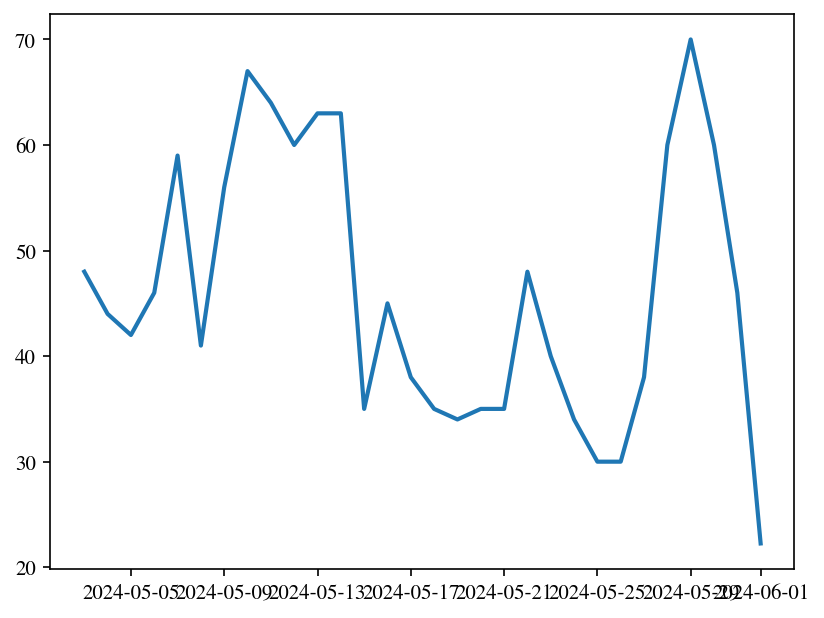

In [117]:
plt.plot(data_normalised.index, data_normalised['trend'])

In [118]:
multi_linear_gl_tr = smf.ols(formula='trend~daily_views+daily_comments+daily_likes', data=data_normalised).fit()
multi_linear_gl_tr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  trend   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.107
Method:                 Least Squares   F-statistic:                   0.06370
Date:                Tue, 04 Jun 2024   Prob (F-statistic):              0.979
Time:                        23:34:47   Log-Likelihood:                -118.71
No. Observations:                  30   AIC:                             245.4
Df Residuals:                      26   BIC:                             251.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         45.5676      3.212     14.188      0.000      38.966      52.169
daily_views        9.6514     28.470      0.339      0.737     -48.870      68.172
daily_comments    -0.5082     17.049     -0.030      0.976     -35.553      34.537
daily_likes       -8.2838     27.029     -0.306      0.762     -63.842      47.274
==============================================================================
Omnibus:                        4.654   Durbin-Watson:                   0.729
Prob(Omnibus):                  0.098   Jarque-Bera (JB):                2.047
Skew:                           0.306   Prob(JB):                        0.359
Kurtosis:                       1.876   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the OLS Regression Results we can find the performance of this model is very bad, R2 almost 0 and p values are very high.

#### Cluster Analysis

In [119]:
trends_cols = all_trends.columns[1:]

1. Read normalized data from csv

In [120]:
def handle_yt_data(df):
    df = df[['date','views','likes','comments']].copy()
    df['date'] = pd.to_datetime(df['date']).dt.date
    return df

path = f'./data/yt_data_1.csv' 
v = pd.read_csv(path)
v1 = handle_yt_data(v)
v1.head()

,date,views,likes,comments
0,2024-05-31,94105,312,0
1,2024-06-01,53393,252,0
2,2024-05-31,29499,162,0
3,2024-05-31,94105,312,0
4,2024-05-31,84117,9,1


In [121]:
yt_data.head()

,views,likes,comments
date,,,
2024-05-03,17894,3611,99
2024-05-03,18462,1718,104
2024-05-03,43857,10830,273
2024-05-04,90220,730,794
2024-05-04,14960,1418,75


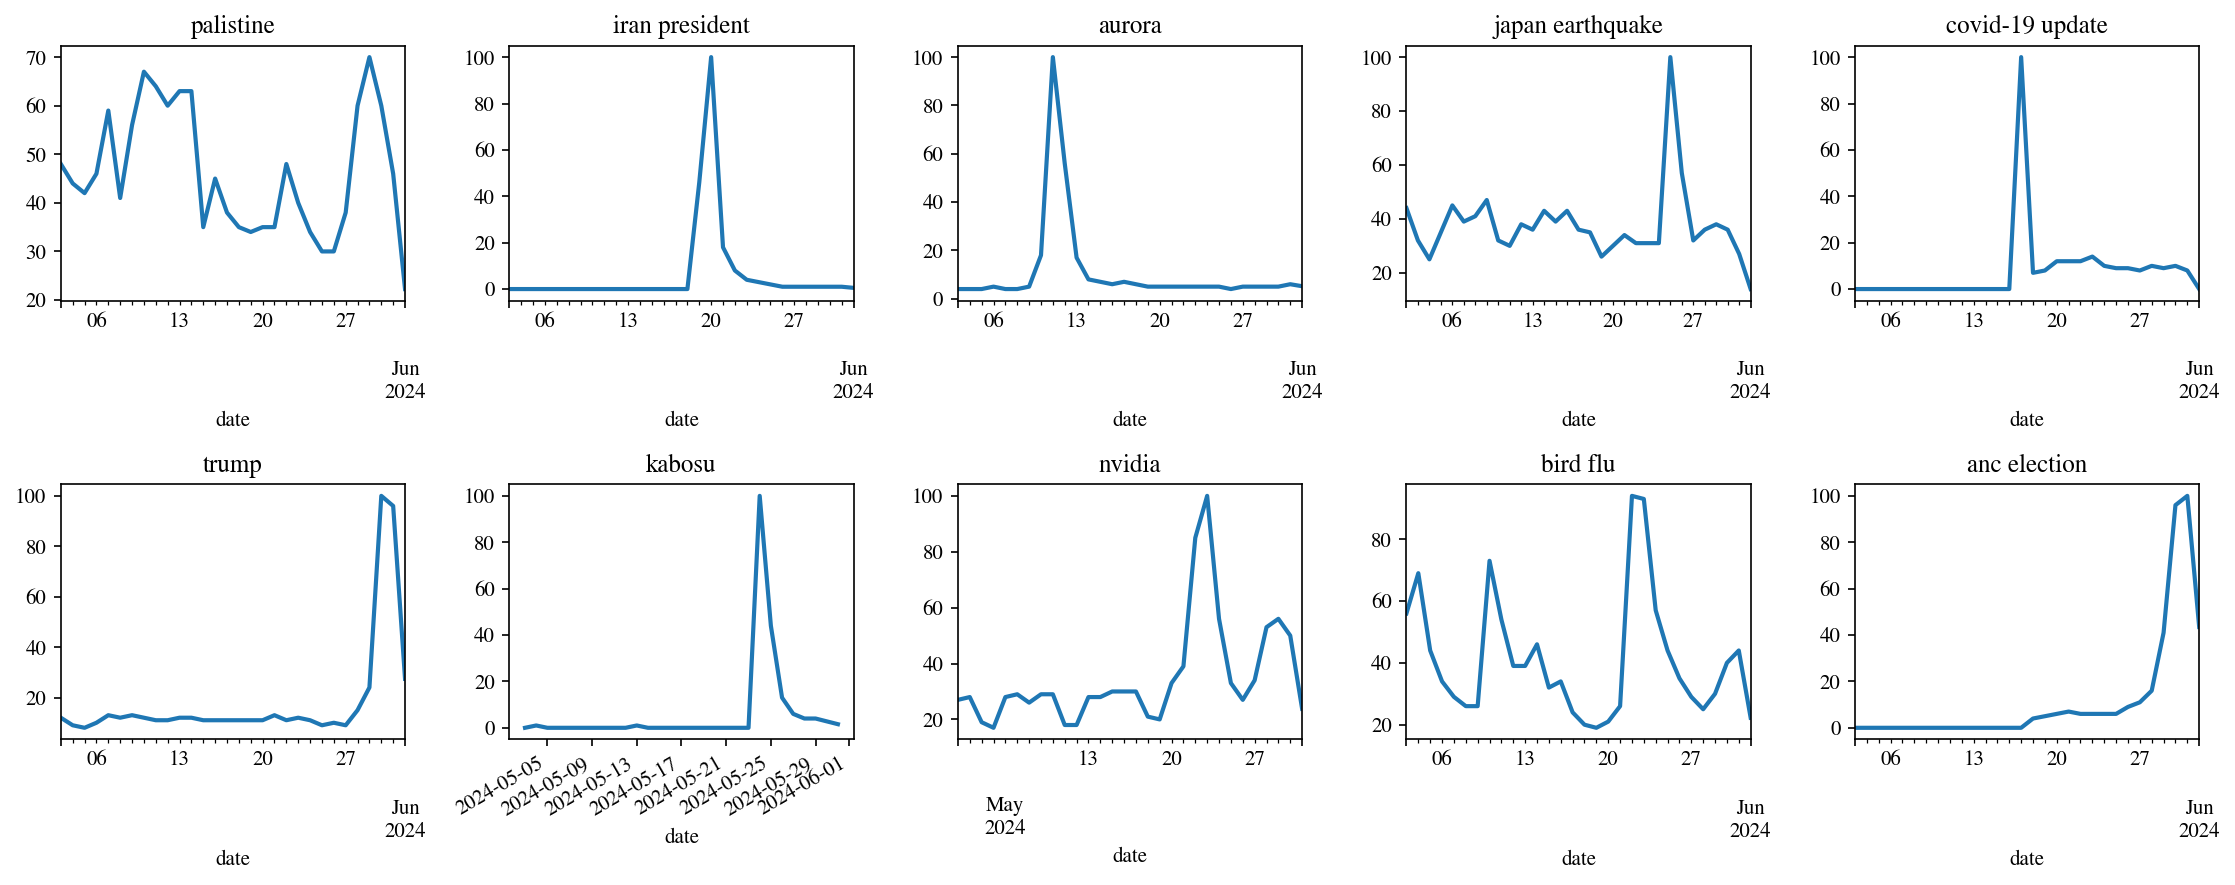

In [122]:
nor_feats_df = []
for i, val in enumerate(trends_cols):
    path = f'./data/yt_data_{i}.csv'
    v = pd.read_csv(path)
    trend = all_trends.loc[:, ["date", all_trends.columns[i+1]]]
    temp = handle_yt_data(v)
    # print(f'columns {temp.columns}, trend column {trend.columns}')
    yt_feat_data, yt_feat_data_normalised = feature_creator.create_features(trend, temp)
    yt_feat_data_normalised['label'] = i
    nor_feats_df.append(yt_feat_data_normalised)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))


for i, val in enumerate(nor_feats_df):
    row = i // 5
    col = i % 5
    val['trend'].plot(ax=axs[row, col])
    axs[row, col].set_title(trends_cols[i])

plt.tight_layout()
plt.show()

2. Select target features and perform k-means cluster

Text(0.5, 1.0, 'Within Cluster Sum of Squares versus number of Clusters')

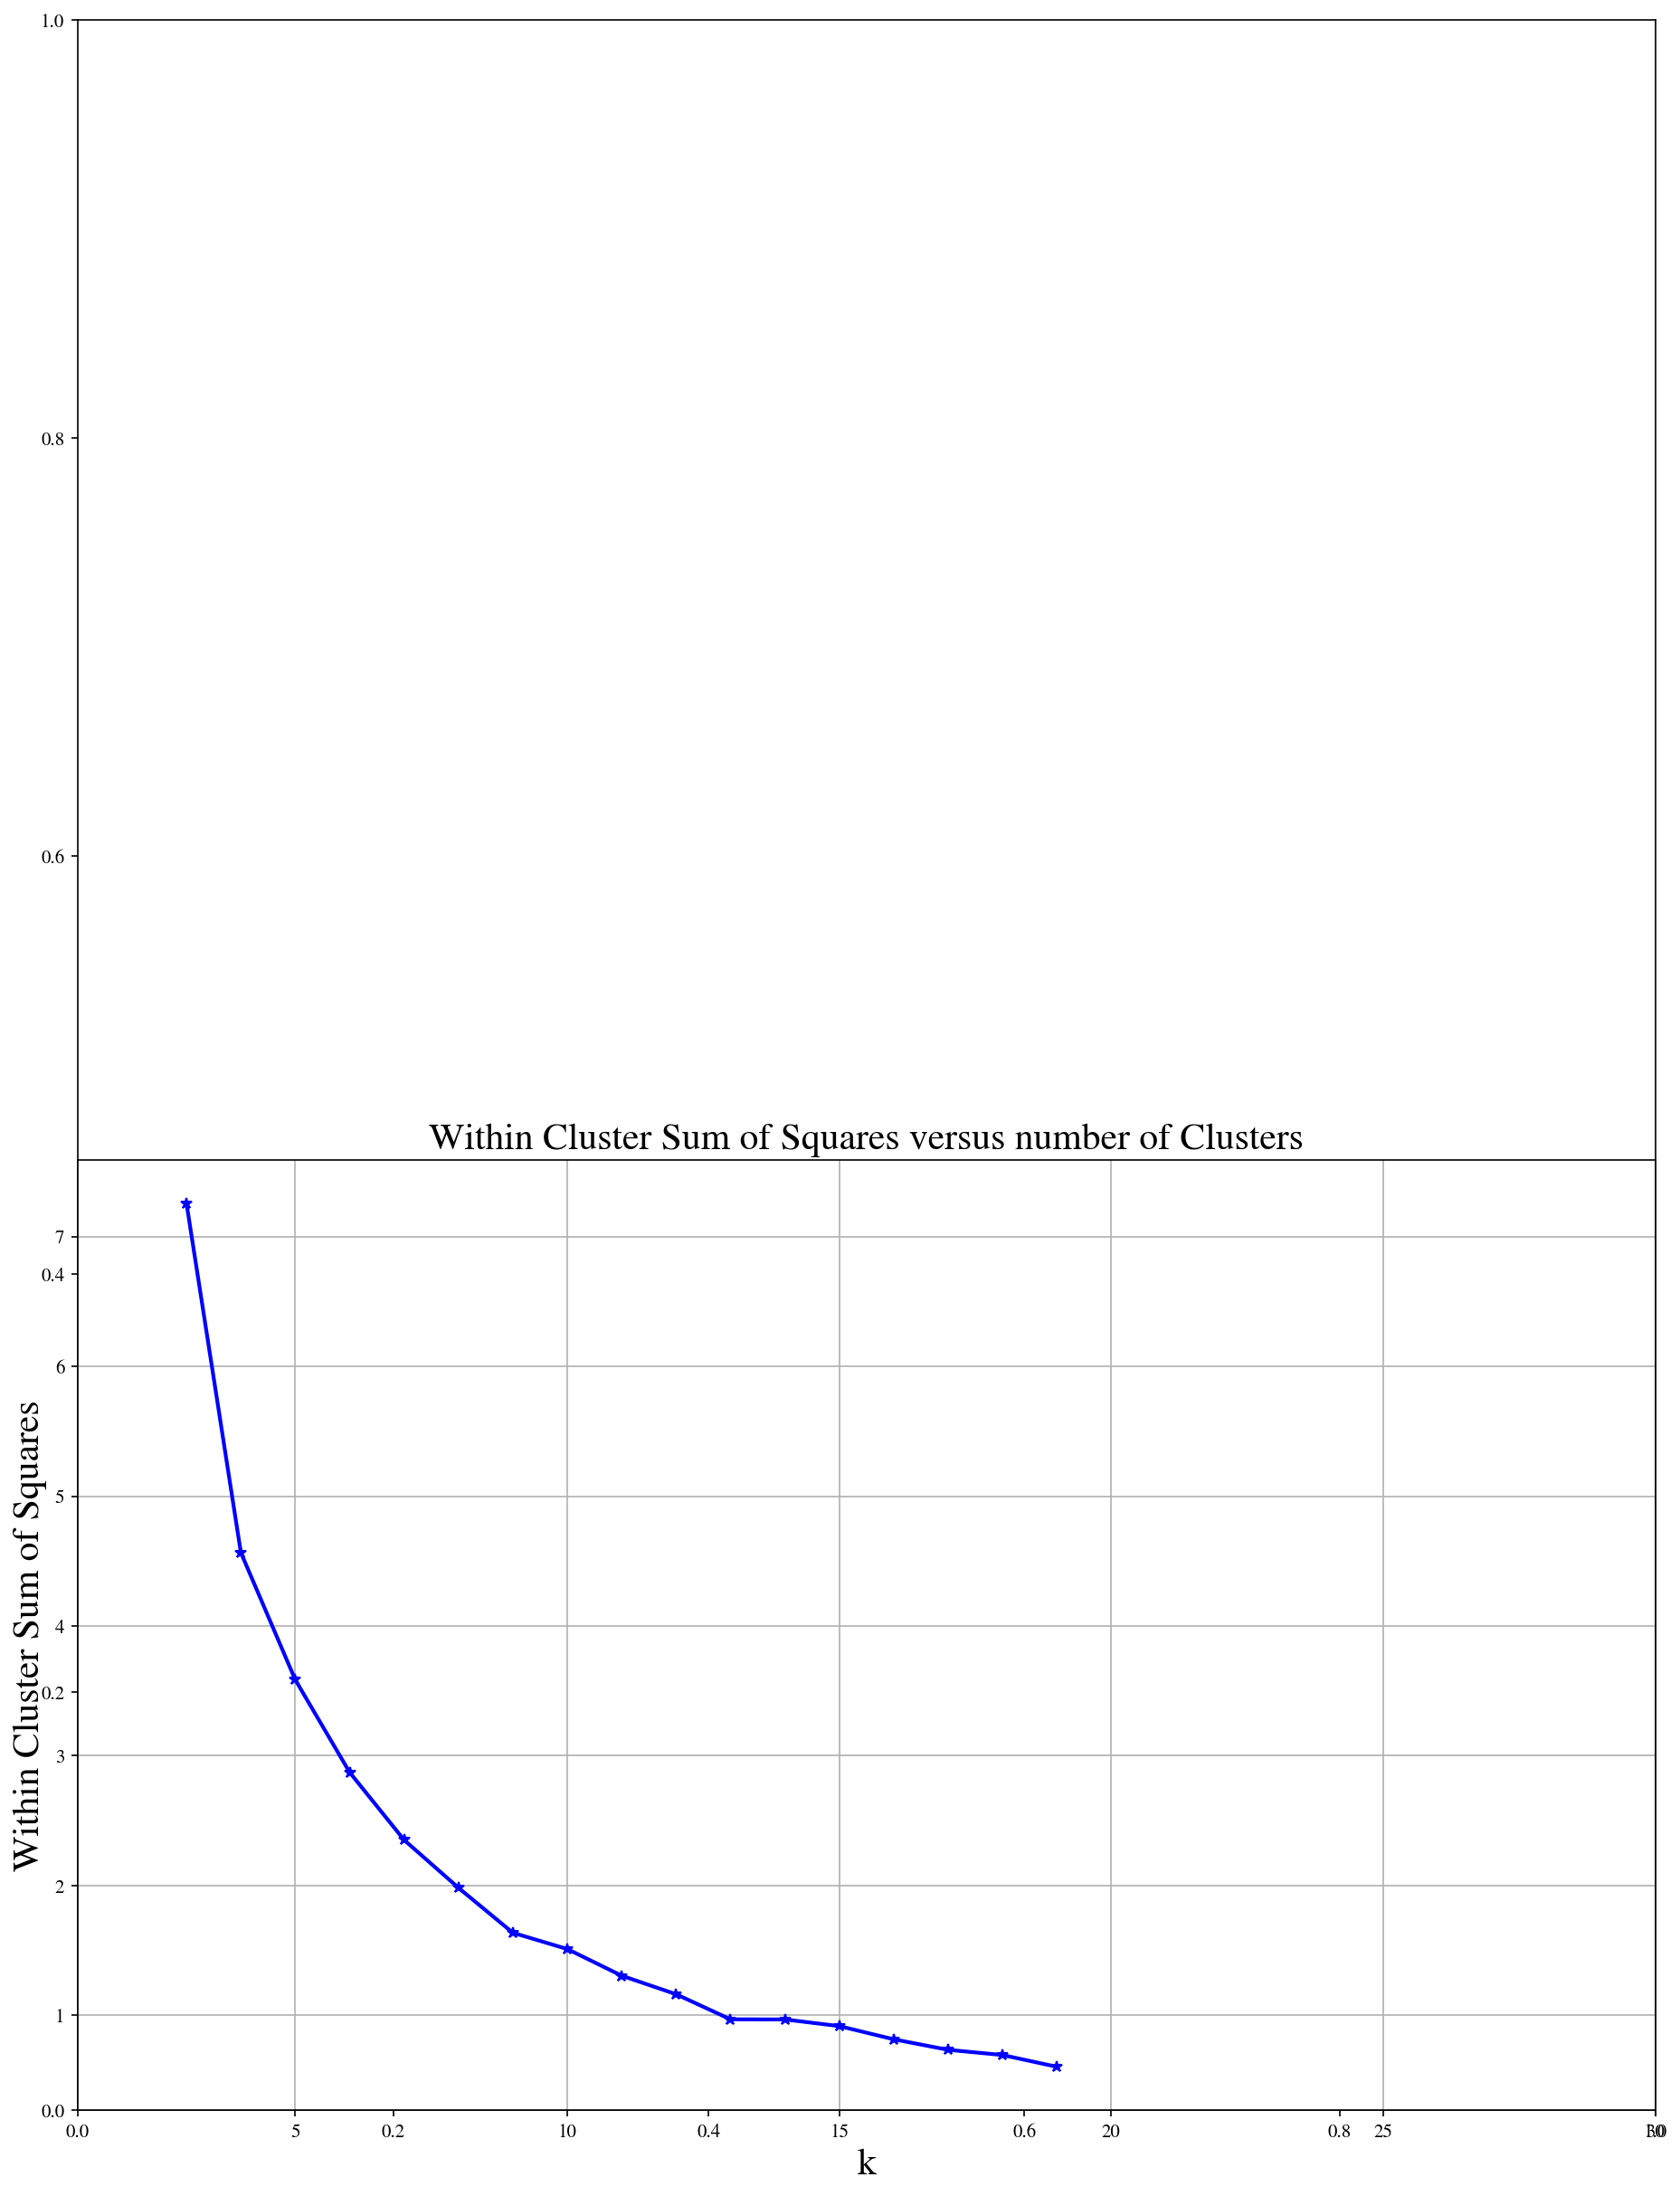

In [123]:
combined_nor_feat_df = pd.concat(nor_feats_df, axis=0) #merge in row
oper_feat = combined_nor_feat_df.iloc[:,[5,6]]

k_rng = range(3,20)
est = [KMeans(n_clusters = k).fit(oper_feat.values) for k in k_rng]

# Generally want to minimize WSS, while also minimizing k
within_cluster_sum_squares = [e.inertia_ for e in est]
fig, axes = plt.subplots()
fig.set_size_inches(15,20)
# Plot the results
plt.subplot(212)
plt.plot(k_rng, within_cluster_sum_squares, 'b*-')
plt.xlim([1,30])
plt.grid(True)
plt.xlabel('k', fontsize=20)
plt.ylabel('Within Cluster Sum of Squares', fontsize=20)
plt.title('Within Cluster Sum of Squares versus number of Clusters', fontsize=20)

Note: k-means clustering result is most obvious when comparing different news items with different time-scale types - defined roughly as short-term = less than 4 weeks, medium-term = 1-3 months, and long-term = 3+ months old.

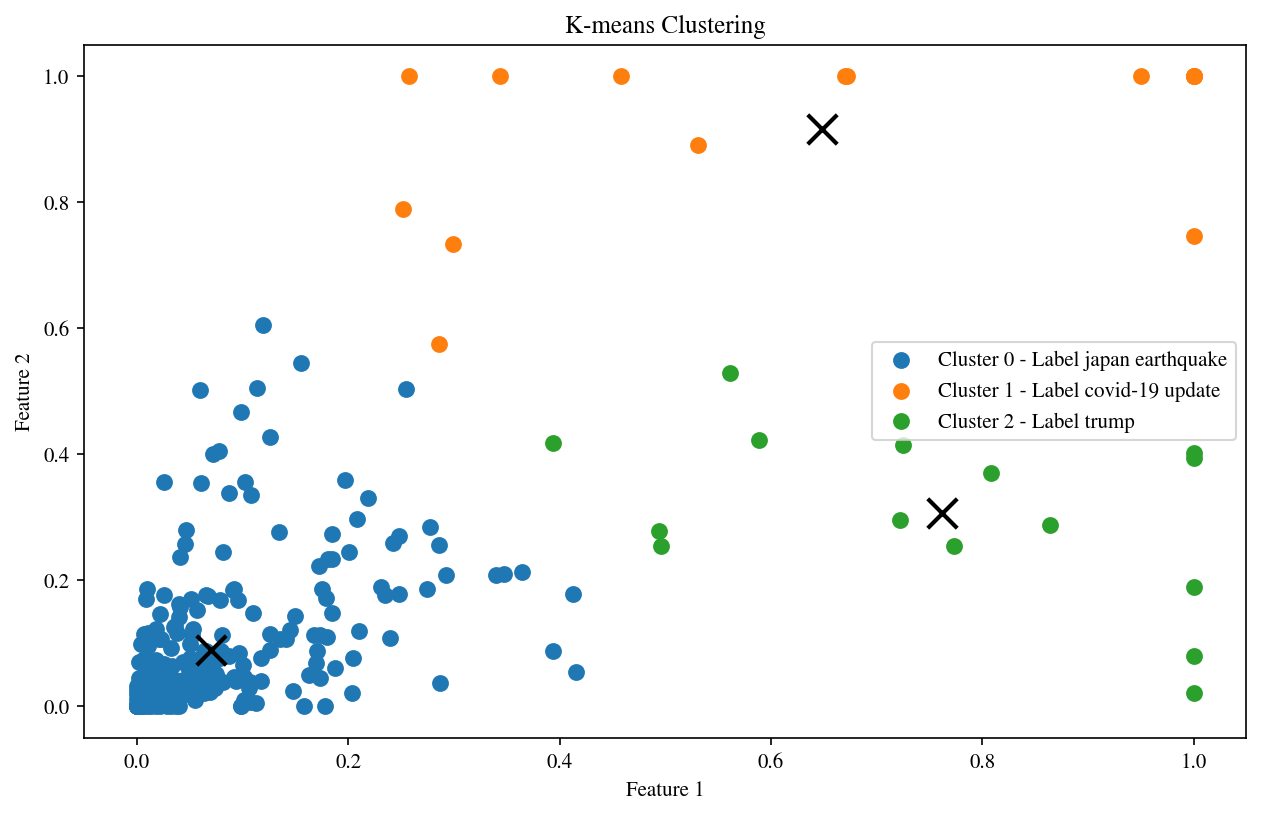

In [124]:
X= oper_feat.values
kmeans = KMeans(n_clusters=3, random_state=0)
y_kmeans = kmeans.fit_predict(X)
y_true = combined_nor_feat_df['label']


labels = np.zeros_like(y_kmeans)
for i in range(3):
    mask = (y_kmeans == i)
    labels[mask] = mode(y_true[mask])[0]

    
centroids = kmeans.cluster_centers_


plt.figure(figsize=(10, 6))
for i in range(3):
    idx = labels[y_kmeans == i][0]
    i_name = trends_cols[idx]
    plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], s=50, label=f'Cluster {i} - Label {i_name}')
    plt.scatter(centroids[i, 0], centroids[i, 1], s=200, c='black', marker='x', edgecolor='k')

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

#### Correlations
Data correlations are also explored in order to find relevant features for inclusion during predictive modelling - although usually a useful tool, due to the nature of this domain and scope of the modelling (with every news item varying in total "news relevancy" length), a generated correlation matrix is more useful as a datapoint, to determine if the output prediction model will be useful/accurate or not, rather than strictly as a tool for feature selection.

The primary information for this use is to determine lineatiy with the target variable "trend" - some correlation is good, but ultra-high collinearity (or having all collinearities be very close to 0) indicates the model will be substandard.

In [125]:
analyser = RunAnalysis()
corr_matrix_norm = analyser.get_corr_matrix(data_normalised)

fig = px.bar(corr_matrix_norm, x='Feature', y='Correlation', title='Feature Correlation to Google Trend')
fig.show()


# Predictive Modelling

Two "phases" of modelling were undertaken - an accuracy testing phase, and a forecasting phase. The code runs the following steps:

1. Models are initialised with a train test split of 0.75 train, 0.25 test. This was iterated and found to be a good balance.
2. Relative accuracy is determined by testing on this split data - we used the mean square error as a relative measure of accuracy.
3. The model is then tasked with making a forecasting prediction on the single row of data separated earlier - today's extrapolated data.
4. Both the accuracy and forecast trend predictions are concatenated, and plotted against the real data.

Many predictive model types were tested, including kNN, decision tree, random forest, LightGBM, linear regression, CNN, 

The code below plots the final model predictions against each of the ten test news items. The severity to which short-term and long-term news items are inadequately predicted can be seen, along with the relatively good prediction MSE's for medium term items such as "anc election", "trump" (long-term but has relative large news in the last few weeks), "nvida" (earnings call run-up occurs over 3 month period), and "bird flu" (topical medium-term news).

Hyper-parameter than affected outcomes the most in the tree models was n_estimators, and around 10 was found to be the most accurate due to the sample size of the data. kNN and linear regression models are likely not worth perusing, due to the relatively low correlations between the variables and the target, dimensionality issues due to the large amount of features relative to sample size, and the fact that some news items work well with some features, and poorly with others.

Predictions for News Item 1 "palistine": 


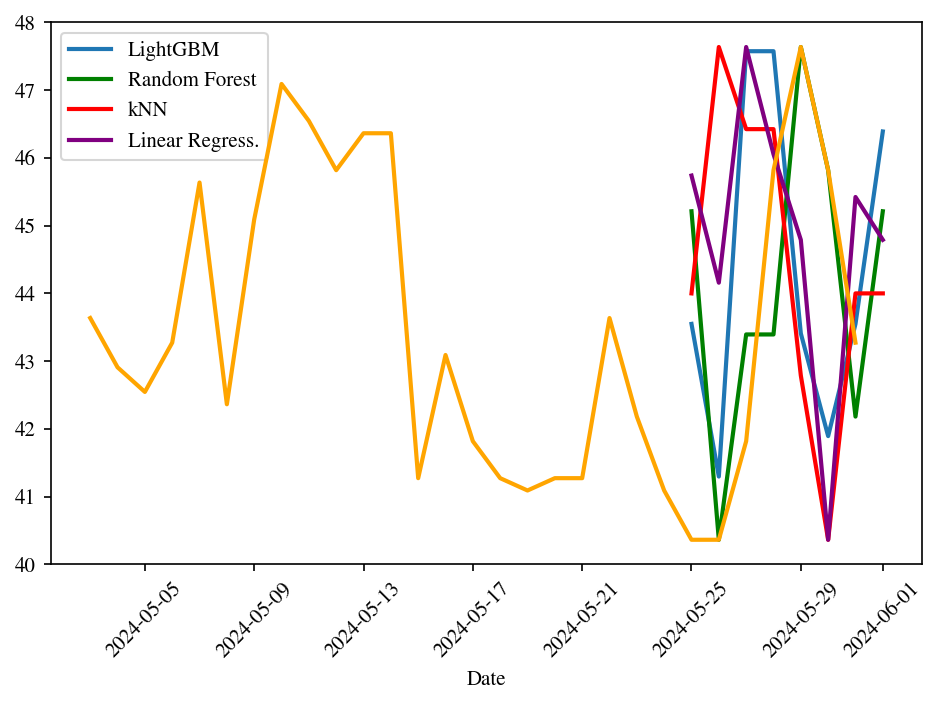

MSE Scores
LightGBM: 228.31294746623615
Random Forest: 183.85714285714286
kNN: 253.57142857142858
Linear Regression: 330.0


Predictions for News Item 2 "iran president": 


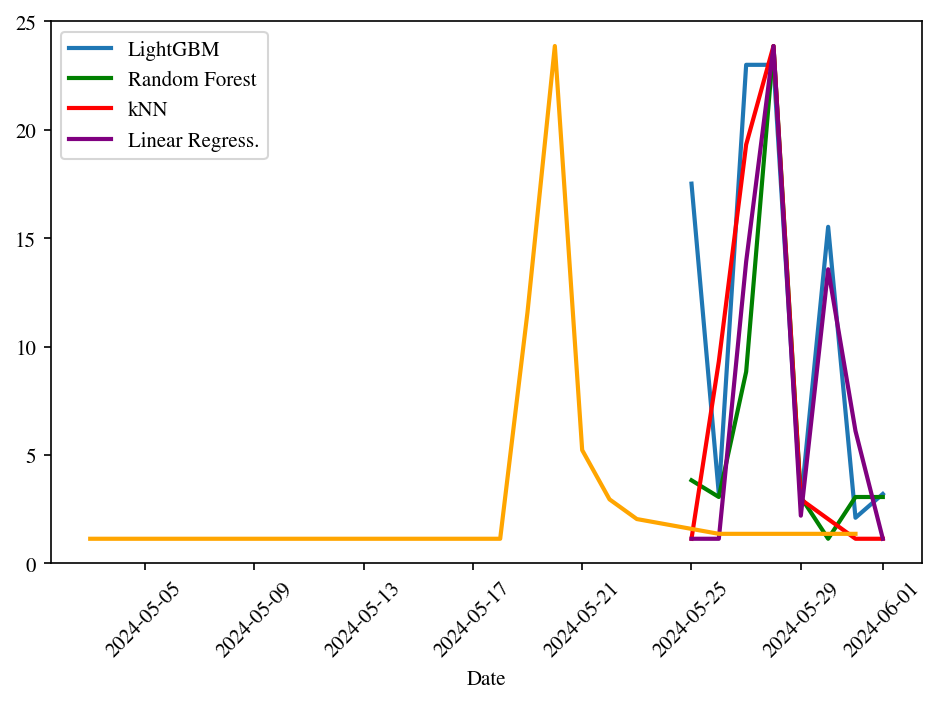

MSE Scores
LightGBM: 204.08063114250007
Random Forest: 542.7142857142857
kNN: 143.85714285714286
Linear Regression: 1015.2857142857143


Predictions for News Item 3 "aurora": 


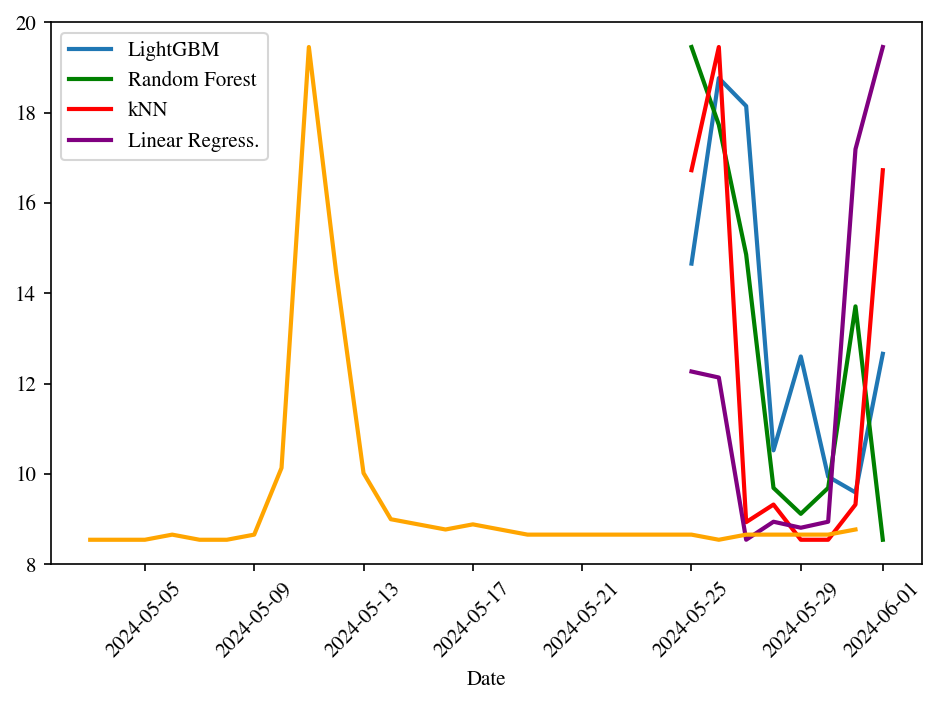

MSE Scores
LightGBM: 87.13005112106048
Random Forest: 259.42857142857144
kNN: 200.42857142857142
Linear Regression: 682.0


Predictions for News Item 4 "japan earthquake": 


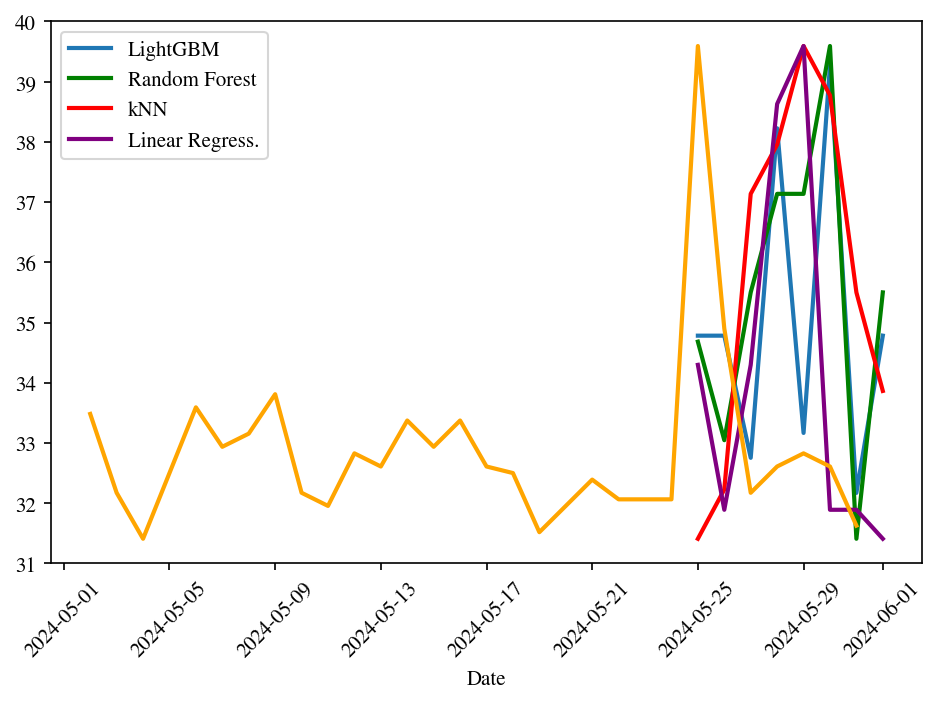

MSE Scores
LightGBM: 687.6303843558977
Random Forest: 694.5714285714286
kNN: 811.7142857142857
Linear Regression: 677.5714285714286


Predictions for News Item 5 "covid-19 update": 


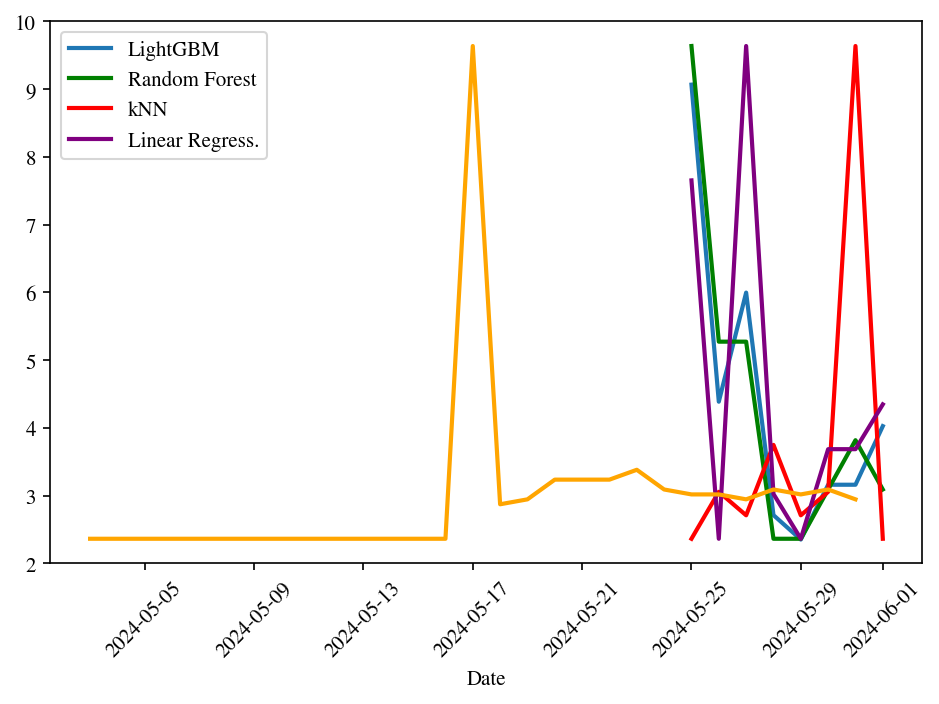

MSE Scores
LightGBM: 27.54076571150343
Random Forest: 48.57142857142857
kNN: 65.0
Linear Regression: 56.142857142857146


Predictions for News Item 6 "trump": 


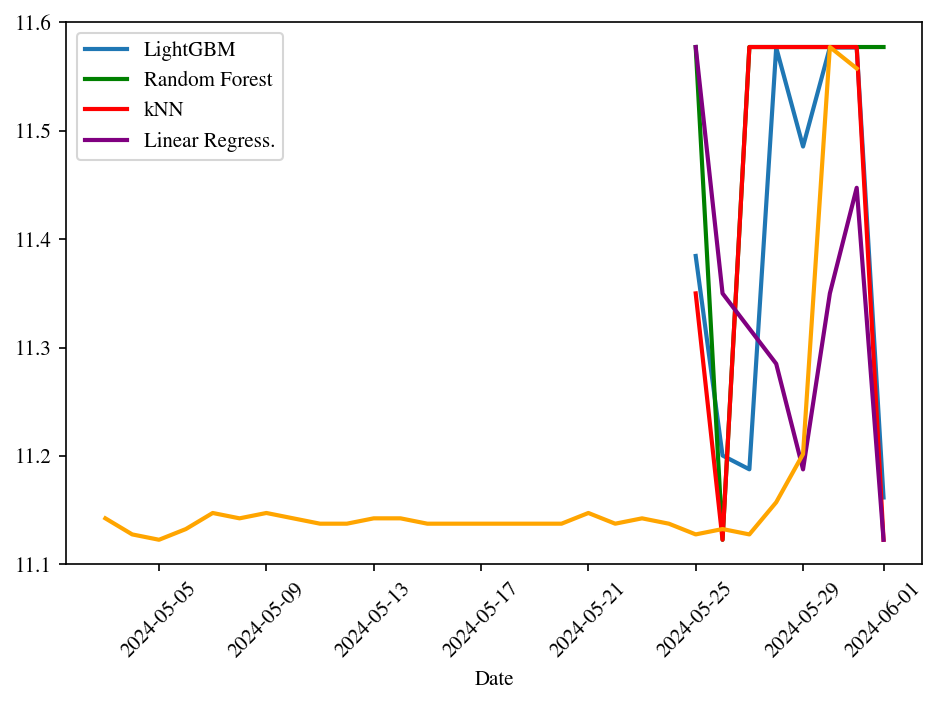

MSE Scores
LightGBM: 2160.88113147373
Random Forest: 2138.8571428571427
kNN: 2138.0
Linear Regression: 2381.714285714286


Predictions for News Item 7 "kabosu": 


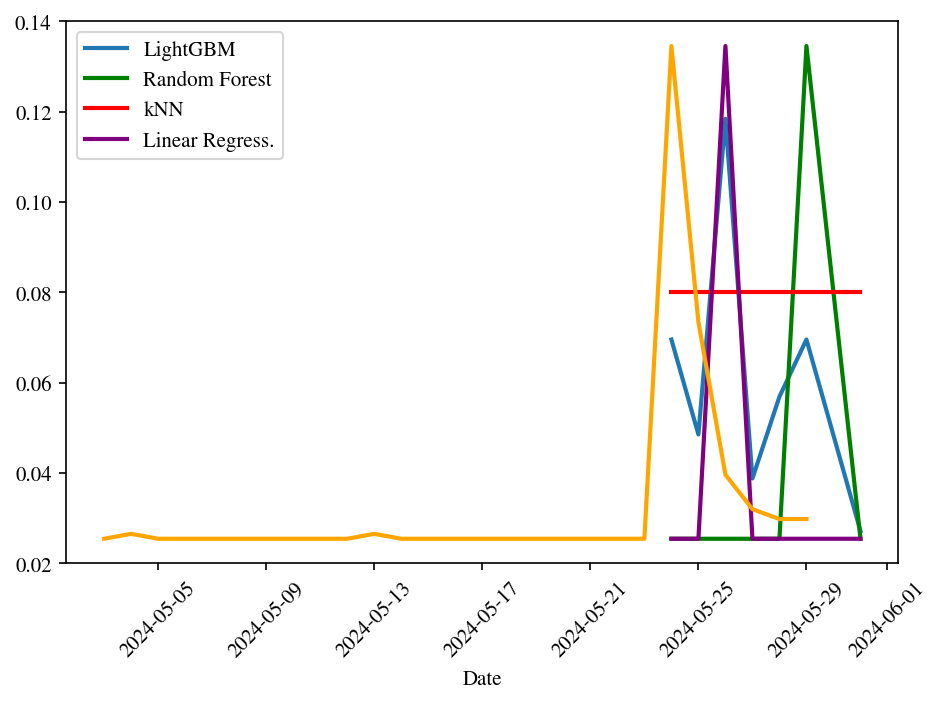

MSE Scores
LightGBM: 2025.0482282351293
Random Forest: 2027.6666666666667
kNN: 2028.8333333333333
Linear Regression: 2041.0


Predictions for News Item 8 "nvidia": 


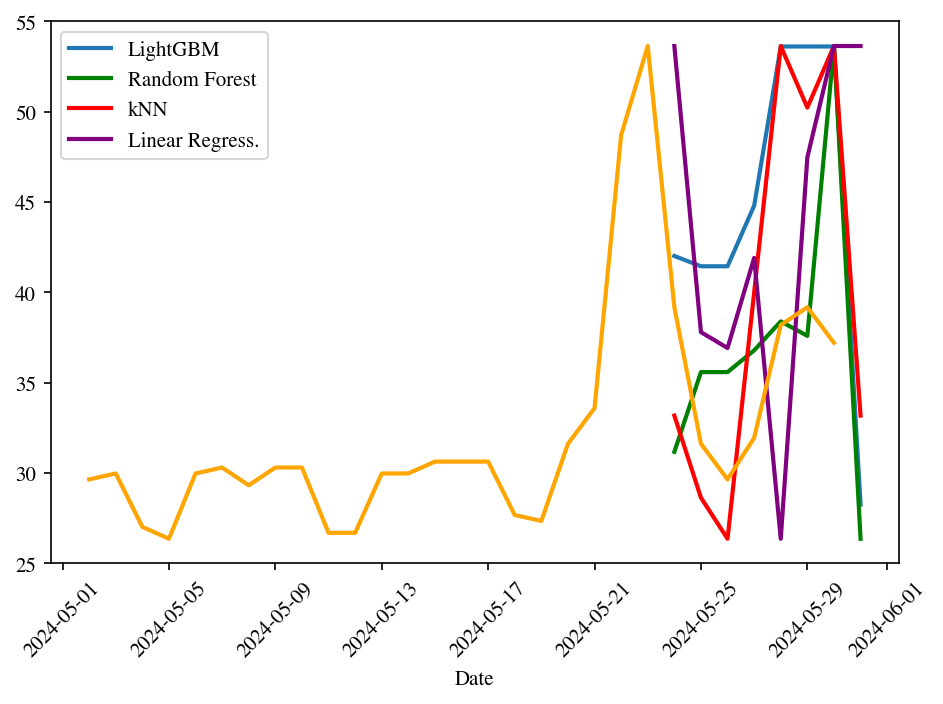

MSE Scores
LightGBM: 87.32589550599228
Random Forest: 556.8571428571429
kNN: 226.14285714285714
Linear Regression: 5650.857142857143


Predictions for News Item 9 "bird flu": 


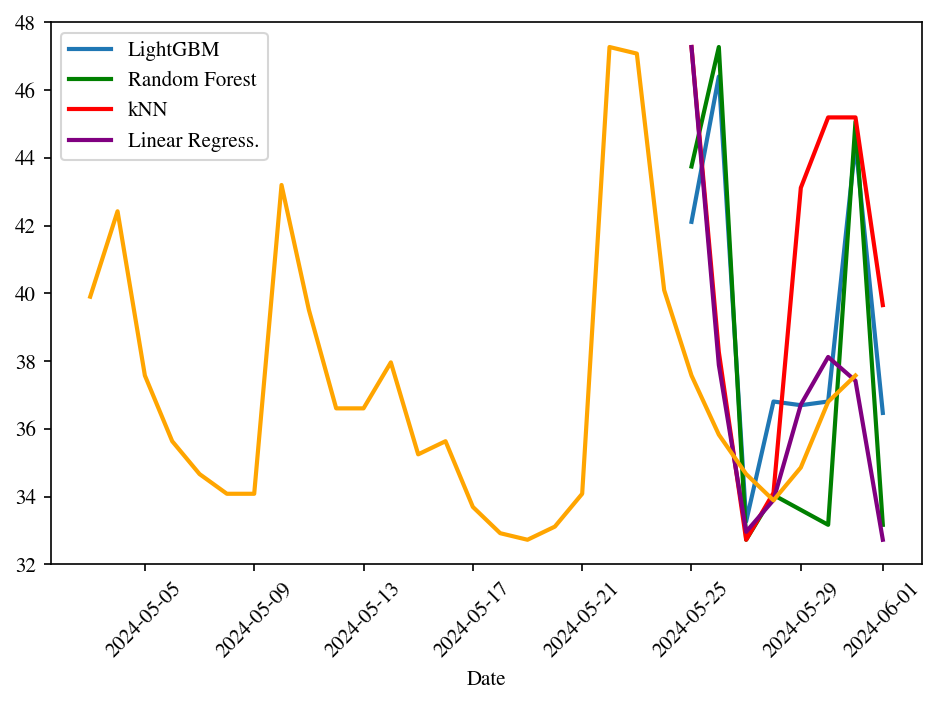

MSE Scores
LightGBM: 49.50089396238788
Random Forest: 309.0
kNN: 59.0
Linear Regression: 933.7142857142857


Predictions for News Item 10 "anc election": 


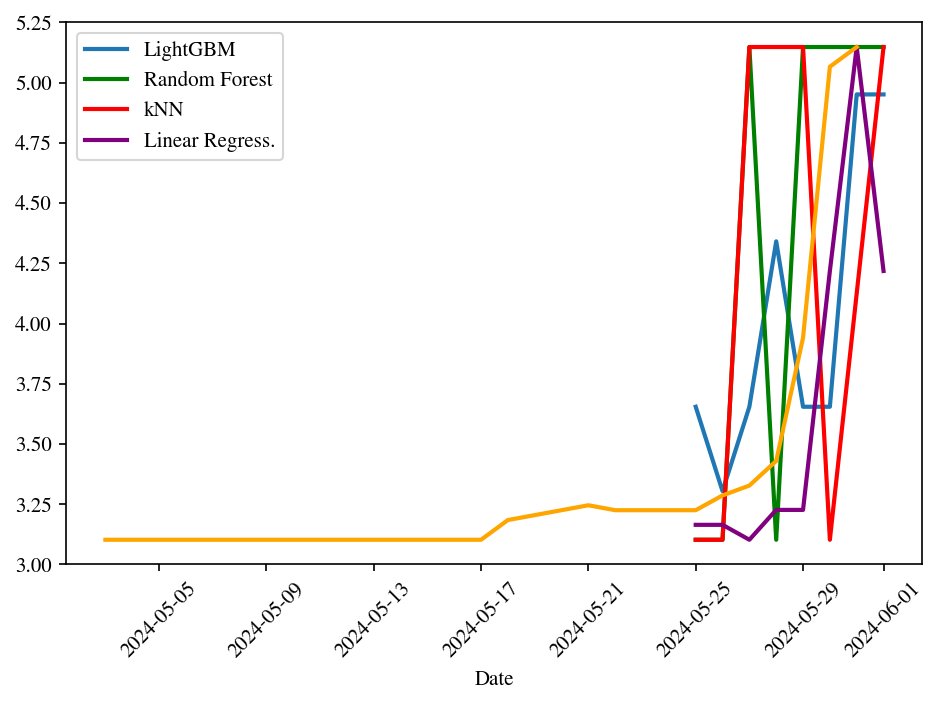

MSE Scores
LightGBM: 2740.6501615189763
Random Forest: 2617.714285714286
kNN: 2913.5714285714284
Linear Regression: 1604.4285714285713




In [126]:
all_trends = pd.read_csv('./data/test_trends_data.csv')
feature_creator = CreateFeatures()
modeller = RunModels()

predictions = []

for i in range(10):
    trend = all_trends.loc[:, ["date", all_trends.columns[i+1]]]
    yt_data = pd.read_csv(f'./data/yt_data_{i}.csv')
    data, data_normalised = feature_creator.create_features(trend, yt_data)
    df_LGBM, df_RF, df_KNN, df_LR, scores = modeller.run_all_models(data_normalised, None)
    
    print(f'Predictions for News Item {i+1} "{all_trends.columns[i+1]}": ')

    x = df_LGBM.index
    fig, ax1 = plt.subplots()
    ax1.plot(x, df_LGBM["prediction"], label='LightGBM')
    ax1.set_xlabel('Date')
    ax1.set_ylim(ax1.get_ylim())
    ax1.set_yticks(ax1.get_yticks())
    ax1.tick_params(axis='x', which='both', rotation=45, labelrotation=45)

    ax2 = ax1.twinx()
    ax2.plot(x, df_RF["prediction"], label='Random Forest', color='g')

    ax3 = ax1.twinx()
    ax3.plot(x, df_KNN["prediction"], label='kNN', color='r')

    ax4 = ax1.twinx()
    ax4.plot(x, df_LR["prediction"], label='Linear Regress.', color='purple')

    ax5 = ax1.twinx()
    ax5.plot(x, df_LGBM["real"], label='Real Trend', color='orange')
    ax5.set_ylabel('Trend', color='orange')
    for ax in [ax2, ax3, ax4, ax5]:
        ax.axis('off')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3 + lines4, labels1 + labels2 + labels3 + labels4, loc='upper left')
    plt.tight_layout()
    plt.show()

    print("MSE Scores")
    print(f'LightGBM: {scores["lightgbm"]}')
    print(f'Random Forest: {scores["randomforest"]}')
    print(f'kNN: {scores["knn"]}')
    print(f'Linear Regression: {scores["linearregression"]}')
    print('')
    print('')

# The Trend Predictor App

Two app ideas were discussed and developed for testing:
1. A static application that shows predictions for the top ten current news items, and;
2. A dynamic application, that allows a user to input their own news item search string, fetch the relevant data, and generate & view the predictive model outcomes for that single item.


Both options were developed, with the first being an executable node.js app - this was ultimately dismissed, as while it functioned, there were two issues:
- It required us to arbitrarily determine what the "top ten" news item search strings were - and all API's that can fetch a current "top ten" list contain full headlines, which we would need to manually extract general search strings from anyway.
- Due to project requirements, Python is required to generate models and analysis - triggering Python files with node.js worked perfectly, but meant a user needed to manually install all required modules, and allow permissions for an executable file to run python scripts. This was a serious problem when testing on other computers, and meant publishing the app publicly would require a special server that could run node.js and python, and allow communication between the two - or a complex cloud microservice system.


We then built the dynamic option in Streamlit - the app works perfectly in local development, but had issues when deployed:
- API calls with PyTrends can sometimes be rejected - we account for this by having a brute-force loop that takes random sleep() breaks between requests. Initial testing showed this worked on Streamlit, but eventually failed.



Unlike node.js and other javascript server solutions, Python servers run completely server-side - this means the I.P. address of Streamlit app GET requests are shared, and if another unrelated app is blocked from making Google Trend requests, so is our app. Google Trend scraping blocks are temporary, and so what likely happened is our testing occurred during off-peak hours for the Streamlit user-base, while deployment was during a higher usage time frame.

This can be "easily" solved by changing the Google Trend/Pytrend request in Javascript, so that it operated client-side, therefore using the client's I.P. address for this request, and not the server's.


The app currently performs well locally and is available from the public Streamlit github repository found at the link below - a fix to the publicly deployed app is pending a javascript conversion of PyTrends.

You can find the app at:

### https://newstrend.streamlit.app/


- The dynamic app example below shows a current report (as of 4/06/2024) of the news item "palistine" - this is pre-labeled as a long-term news item, and so the predictive model outcomes are poor.

- The state app example below is for ideation purposes only - as we discarded the idea, the model code was not updated to our final models (it showed larger forecastings than are justifiable, at 7 days).

#### Final Dynamic App - Landing Page
![Dynamic App Landing Page](images/dynamic%20app%20-%20landing.png)

#### Final Dynamic App - Generated Report Page
![Dynamic App Landing Page](images/dynamic%20app%20-%20report%201.png)

#### Inital Static App - Landing Page
![Dynamic App Landing Page](images/static%20app%20-%20landing.png)

#### Inital Static App - Pre-Generated Report Page
![Dynamic App Landing Page](images/static%20app%20-%20report%201.png)

# Conclusion 

The development of The News Trend Predictor app provided valuable insights into the complexities of predictive modelling for news trends - and the diversity of techniques required to "get it right". One of the primary challenges we encountered was accessing high-quality historical data due to stringent requirements from platforms like X, Meta, and TikTok, or the complete lack of availability outside of enterprise-level subscriptions. This obstacle led us to pivot towards using YouTube and Google Trends data, which were more accessible but also was a relevant measure of popularity. This decision allowed us to streamline our data analysis process and improve the overall quality of our findings, as including more data sources may have improved the model, but also would have increased the complexity of this project.
Additionally, the app development process taught us the importance of client vs. server-side GET request fetching, and how to better manage data source limitations.


#### Main Challenges
Data Collection:
API Issues - Many websites, including major platforms such as Meta and TikTok, require application registration, the upload of personal identification, and a clear explanation of the data collection purpose.

API Call Restrictions:
The imposed limit of 600 API calls can be restrictive. For instance, processing a single video might necessitate 600 API calls. Processing multiple videos will thus exceed the API call limit, necessitating careful management and optimization.

Modeling Scope:
Retrospectively, it would have served us well to further limit the scope of this project to only specific types of news after completing cluster analysis, and incorporating the k-means model into the app, or avoiding predictions completely and focusing on news classification - determining if a news item is a "flash in the pan" or is maintaining it's trend in popularity would also be a userful tool for the target users!

Overfitting Concerns:
The potential for model overfitting is heightened due to the presence of high correlations among many features.
Iterative Modeling: Emphasizing the importance of iterative modeling to address and mitigate the overfitting issue and enhance model performance.


### Research Findings
1. Predictive algorithms are only effective in predicting the populatity trend of individual news items when those news items have a relative time-scale roughly equal to the amount of training and testing data used - if too much or too little data is used, mean square error values hike massively. An extra algorithm (or additional data scraping) or a highly accurate clustering method must be intregrated in the report generation process to confirm if it is appropriate to make predictions on the chosen news item.
2. Data quality is incredibley important in making reliable trend forecasts, but not as important as news item categorisation.
3. There is an inferred correlative relationship between news items and our arbitrary time-scale categorisations (short, medium, and long-term) - and it is possible that further sub-categorisations exist and are needed for data validation.
4. Decision tree based algorithms were most effective overall, likely because they take better account of categorisation variables, as opposed to other models which work better with continuous variables and variables higher correlations with the target, and struggle with high dimensionality of features.


### Further Works
- A potential way to increase the usability and improve the appropriateness of this modelling strategy would be to convert the continuous "trend" target into a binary target for each day; 0 for a downtrend, and 1 for an uptrend. This way, likelihood is strictly predicted, and not overall trend proportion. This would also be simpler for users to interpret, as opposed to having to interpret a "Google Trend", which is normalised and relative.
- As mentioned, pivoting the tool to a classifying system would likely be more appropriate, easier to implement, and potentially more useful than short-term trend forecasting.
